In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 가격 csv
df=pd.read_csv('price.csv')
df = df.iloc[:,:-3]
first_row = df.iloc[0, 1:]
for i in range(len(df.index)-1):
    next_row = df.iloc[i+1, 1:]
    first_row = pd.concat([first_row, next_row])
data = first_row.reset_index()
data.columns = ['time', 'value']
value_price = data['value']

In [3]:
# 에너지 수요 csv
df=pd.read_csv('energy.csv', encoding='cp949')
first_row = df.iloc[0, 1:]
for i in range(len(df.index)-1):
    next_row = df.iloc[i+1, 1:]
    first_row = pd.concat([first_row, next_row])
data = first_row.reset_index()
data.columns = ['time', 'value']
value_energy = data['value']

In [4]:
# 에너지 공급 csv
df=pd.read_csv('generate.csv', encoding='cp949')
first_row = df.iloc[0, 1:]
for i in range(len(df.index)-1):
    next_row = df.iloc[i+1, 1:]
    first_row = pd.concat([first_row, next_row])
data = first_row.reset_index()
data.columns = ['time', 'value']
value_generate = data['value']

In [5]:
# scale data for each dataset
from sklearn.preprocessing import MinMaxScaler

scaler1=MinMaxScaler(feature_range=(0,1))
value_price=scaler1.fit_transform(np.array(value_price).reshape(-1,1))

In [6]:
scaler2=MinMaxScaler(feature_range=(0,1))
value_energy=scaler2.fit_transform(np.array(value_energy).reshape(-1,1))

In [7]:
scaler3=MinMaxScaler(feature_range=(0,1))
value_generate=scaler3.fit_transform(np.array(value_generate).reshape(-1,1))

In [8]:
# energy
# train and test split
training_size=int(len(value_energy)*0.9)
test_size=len(value_energy)-training_size
train_data,test_data=value_energy[0:training_size,:], value_energy[training_size:len(value_energy),:1]

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(16,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

#model.summary()
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

model.save('model1.h5')

model = tf.keras.models.load_model('model1.h5')

x_input = test_data[len(test_data)-100:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<24):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

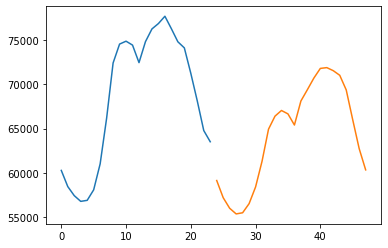

In [11]:
# plot
hour_new=np.arange(0,24)
hour_pred=np.arange(24,48)
plt.plot(hour_new, scaler2.inverse_transform(value_energy[len(value_energy)-24:]))
plt.plot(hour_pred, scaler2.inverse_transform(lst_output))
plt.show()

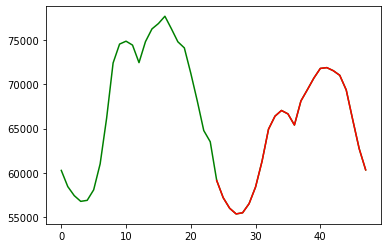

In [70]:
x = np.arange(0,48)
y = np.concatenate((scaler2.inverse_transform(value_energy[len(value_energy)-24:]),scaler2.inverse_transform(lst_output)))

x_1 = x[24:48]
y_1 = y[24:48]
plt.plot(x,y,'g')
plt.plot(x_1,y_1,'r')
plt.show()

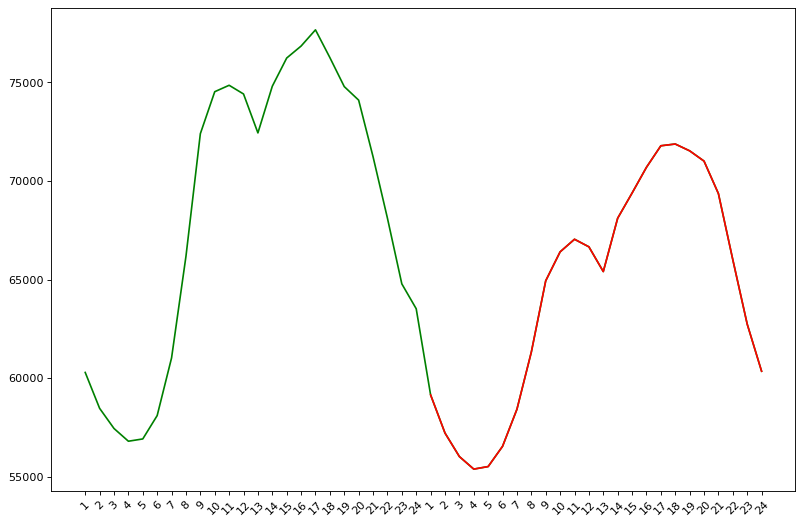

In [75]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
x = np.arange(0,48)
y = np.concatenate((scaler2.inverse_transform(value_energy[len(value_energy)-24:]),scaler2.inverse_transform(lst_output)))
xi = list(range(len(x)))
x_1 = x[24:48]
y_1 = y[24:48]
plt.xticks(xi, x)
plt.plot(x,y,'g')
plt.plot(x_1,y_1,'r')
plt.ticklabel_format(style='plain',axis='y')
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
plt.xticks(xi, x, rotation=45)
plt.savefig("energy.jpg")
plt.show()

In [13]:
# generate
# train and test split
training_size=int(len(value_generate)*0.9)
test_size=len(value_generate)-training_size
train_data,test_data=value_generate[0:training_size,:], value_generate[training_size:len(value_generate),:1]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(16,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

#model.summary()
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

model.save('model2.h5')

model = tf.keras.models.load_model('model2.h5')

x_input=test_data[len(test_data)-100:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output_g=[]
n_steps=100
i=0
while(i<24):
    
    if(len(temp_input)>100):
        
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        if yhat[0] < 0:
            yhat[0]=0
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output_g.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        if yhat[0] < 0:
            yhat[0]=0
        temp_input.extend(yhat[0].tolist())
        lst_output_g.extend(yhat.tolist())
        i=i+1

Epoch 1/50
81/81 [==============================] - 10s 77ms/step - loss: 0.0460 - val_loss: 0.0263
Epoch 2/50
81/81 [==============================] - 5s 66ms/step - loss: 0.0239 - val_loss: 0.0165
Epoch 3/50
81/81 [==============================] - 5s 68ms/step - loss: 0.0197 - val_loss: 0.0148
Epoch 4/50
81/81 [==============================] - 6s 68ms/step - loss: 0.0176 - val_loss: 0.0147
Epoch 5/50
81/81 [==============================] - 6s 69ms/step - loss: 0.0145 - val_loss: 0.0106
Epoch 6/50
81/81 [==============================] - 6s 69ms/step - loss: 0.0120 - val_loss: 0.0127
Epoch 7/50
81/81 [==============================] - 6s 68ms/step - loss: 0.0117 - val_loss: 0.0091
Epoch 8/50
81/81 [==============================] - 6s 69ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 9/50
81/81 [==============================] - 6s 69ms/step - loss: 0.0088 - val_loss: 0.0067
Epoch 10/50
81/81 [==============================] - 6s 70ms/step - loss: 0.0079 - val_loss: 0.0064
Epoch 11

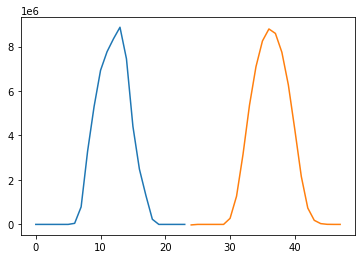

In [14]:
hour_new=np.arange(0,24)
hour_pred=np.arange(24,48)
plt.plot(hour_new, scaler3.inverse_transform(value_generate[len(value_generate)-24:]))
plt.plot(hour_pred, scaler3.inverse_transform(lst_output_g))
plt.show()

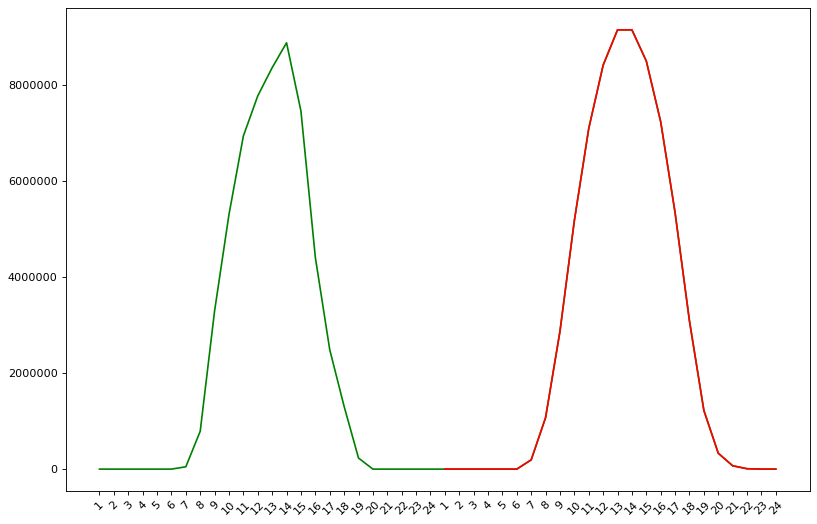

In [76]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
x = np.arange(0,48)
y = np.concatenate((scaler3.inverse_transform(value_generate[len(value_generate)-24:]),scaler3.inverse_transform(lst_output_g)))
xi = list(range(len(x)))
x_1 = x[24:48]
y_1 = y[24:48]
plt.xticks(xi, x)
plt.plot(x,y,'g')
plt.plot(x_1,y_1,'r')
plt.ticklabel_format(style='plain',axis='y')
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
plt.xticks(xi, x, rotation=45)
plt.savefig("generate.jpg")
plt.show()

In [17]:
X = np.hstack((value_energy,value_generate))

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=1000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=5,
                                min_samples_split=45,
                                loss='huber',
                                random_state=42) 

In [20]:
gbr.fit(X, value_price)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=5,
                          min_samples_split=45, n_estimators=1000,
                          random_state=42)

In [23]:
predicted_24 = np.hstack((np.asarray(lst_output),np.asarray(lst_output_g)))

In [24]:
price_predict = gbr.predict(predicted_24)
price = []
for i in range(len(price_predict)):
    price.append([price_predict[i]])

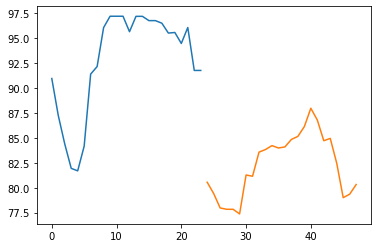

In [25]:
hour_new=np.arange(0,24)
hour_pred=np.arange(24,48)
plt.plot(hour_new, scaler1.inverse_transform(value_price[len(value_price)-24:]))
plt.plot(hour_pred, scaler1.inverse_transform(price))

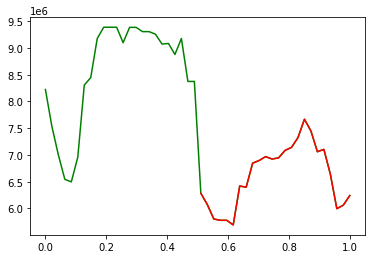

In [35]:
x = np.linspace(0, 1, 48)
y = np.concatenate((scaler3.inverse_transform(value_price[len(value_price)-24:]),scaler3.inverse_transform(price)))

x_1 = x[24:48]
y_1 = y[24:48]
plt.plot(x,y,'g')
plt.plot(x_1,y_1,'r')
plt.show()

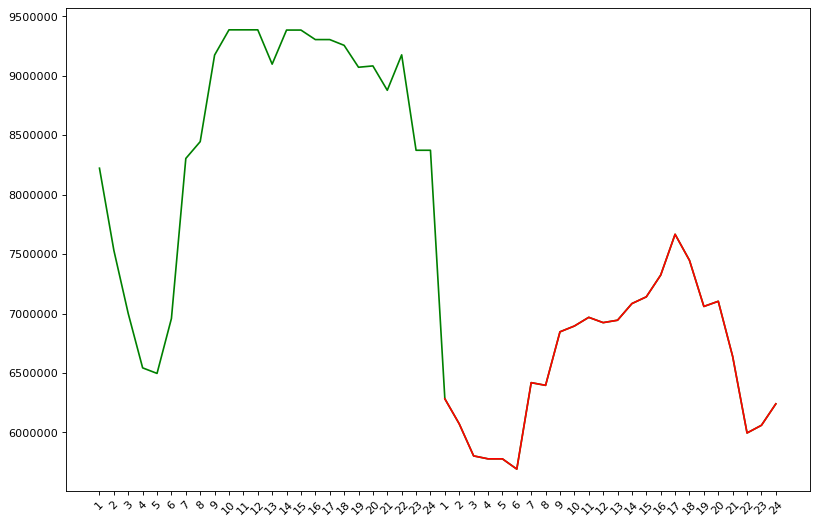

In [77]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
x = np.arange(0,48)
y = np.concatenate((scaler3.inverse_transform(value_price[len(value_price)-24:]),scaler3.inverse_transform(price)))
xi = list(range(len(x)))
x_1 = x[24:48]
y_1 = y[24:48]
plt.xticks(xi, x)
plt.plot(x,y,'g')
plt.plot(x_1,y_1,'r')
plt.ticklabel_format(style='plain',axis='y')
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
plt.xticks(xi, x, rotation=45)
plt.savefig("price.jpg")
plt.show()